In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [2]:
df=pd.read_csv("campaign_data_cleaned.csv")

In [3]:

# 1. Define the target variable
threshold = df['response_count'].median()
df['response_flag'] = (df['response_count'] >= threshold).astype(int)

In [4]:
# 2. Select features for modeling
features = ["prdt_type", "brand", "milestone", "target_group", "campaign_month", "cust_segment"]
X_categorical = df[features]
y = df["response_flag"]





In [5]:

# 3. One-hot encode categorical features
encoder = OneHotEncoder(drop="first", sparse=False)
X_encoded = encoder.fit_transform(X_categorical)

In [6]:

# Get encoded feature names for reference
encoded_feature_names = encoder.get_feature_names_out(features)

# Convert to DataFrame
X = pd.DataFrame(X_encoded, columns=encoded_feature_names)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1888, 399), (472, 399), (1888,), (472,))

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# 1. Train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [9]:
# 2. Predict probabilities and labels
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [10]:
# 3. Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

In [11]:
# 4. Feature importance (coefficients)
coefficients = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", key=abs, ascending=False).head(10)

accuracy, roc_auc, conf_matrix, pd.DataFrame(report).T, coefficients


(0.8389830508474576,
 0.9330369971264367,
 array([[199,  41],
        [ 35, 197]], dtype=int64),
               precision    recall  f1-score     support
 0              0.850427  0.829167  0.839662  240.000000
 1              0.827731  0.849138  0.838298  232.000000
 accuracy       0.838983  0.838983  0.838983    0.838983
 macro avg      0.839079  0.839152  0.838980  472.000000
 weighted avg   0.839272  0.838983  0.838992  472.000000,
                                  feature  coefficient
 9                  target_group_Targeted     3.673272
 20       cust_segment_-Recall Exam NV-TG    -2.650142
 157            cust_segment_EGRecall15NV    -2.515680
 8                    milestone_27 Months    -2.400879
 220            cust_segment_EGRecall24NV    -2.211929
 352       cust_segment_NVIPC647-CA EG MV    -2.084976
 354      cust_segment_NVIPC647-Recall-TG    -2.050544
 6                    milestone_21 Months    -2.028531
 335      cust_segment_NVIPC636-Recall-TG    -1.939169
 398  cust

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt


In [13]:

# 1. Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [14]:
# 2. Predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [15]:

# 3. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8389830508474576
ROC AUC: 0.9031429597701148
Confusion Matrix:
 [[198  42]
 [ 34 198]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84       240
           1       0.82      0.85      0.84       232

    accuracy                           0.84       472
   macro avg       0.84      0.84      0.84       472
weighted avg       0.84      0.84      0.84       472



In [16]:
# 4. Feature Importance
importances = rf_model.feature_importances_
features = X_train.columns


In [17]:

# Create DataFrame and sort
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(10)

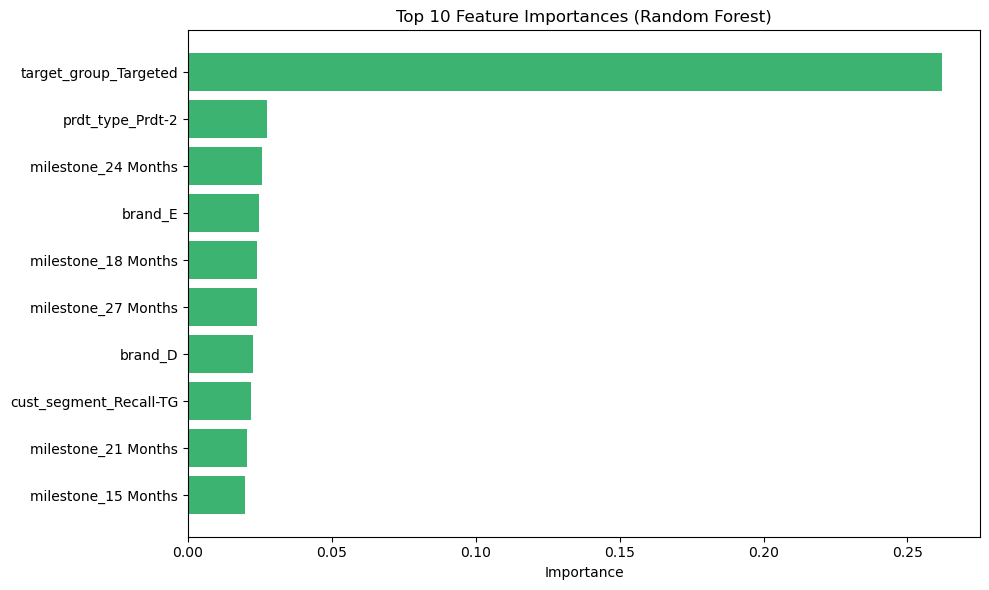

In [18]:
# 5. Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='mediumseagreen')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
# Score all customers
df["response_score"] = rf_model.predict_proba(X)[:, 1]

In [20]:
# Show customers by score
df_scored = df[["prdt_type", "milestone", "campaign_month", "cust_segment", "response_score"]]
top_customers = df_scored.sort_values(by="response_score", ascending=False)


In [21]:
top_customers

,prdt_type,milestone,campaign_month,cust_segment,response_score
778,Prdt-2,15 Months,AUGUST,EGRecallSV14TXNVCA,1.0
861,Prdt-2,15 Months,DECEMBER,NVIPC645-Recall-TG,1.0
309,Prdt-1,15 Months,JANUARY,NVIPC764-Recall-TG,1.0
2001,Prdt-2,12 Months,JUNE,EGRecall12NONFS,1.0
2000,Prdt-2,12 Months,JUNE,EGRecall12NONFS,1.0
...,...,...,...,...,...
447,Prdt-1,18 Months,JULY,CLRecall18ExamControl,0.0
282,Prdt-1,24 Months,OCTOBER,NVIPC636-CL Recall,0.0
278,Prdt-1,24 Months,OCTOBER,NVIPC634-CL Invite,0.0
449,Prdt-1,18 Months,JULY,CLRecall18PromoControl,0.0


In [22]:
df

,prdt_type,brand,milestone,target_group,campaign_month,selected_qty,mailed_count,response_count,response_sales_amt,cust_segment,response_rate_percentage,sales_per_mailed,response_flag,response_score
0,Prdt-1,B,12 Months,Targeted,AUGUST,809,809,98,23323.47,CLClubInvite12,12.113721,28.830000,1,0.990
1,Prdt-1,B,12 Months,Control,AUGUST,90,90,3,686.98,CLClubInvite12Control,3.333333,7.633111,0,0.100
2,Prdt-1,B,12 Months,Targeted,AUGUST,1769,1769,142,30641.22,CLRecall12,8.027134,17.321210,1,0.970
3,Prdt-1,B,12 Months,Control,AUGUST,196,196,16,3261.56,CLRecall12Control,8.163265,16.640612,1,0.860
4,Prdt-1,B,12 Months,Targeted,AUGUST,205,205,16,2848.48,CLRecallTXandCA12,7.804878,13.895024,1,0.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,Prdt-2,E,27 Months,Control,OCTOBER,794,1,0,0.00,RecallNONFirstSight-CG,0.000000,0.000000,0,0.005
2356,Prdt-2,E,27 Months,Targeted,OCTOBER,64494,36,0,0.00,RecallNONFirstSight-TG,0.000000,0.000000,0,0.000
2357,Prdt-2,E,27 Months,Targeted,OCTOBER,71670,34,0,0.00,RecallNONFirstSight-TG,0.000000,0.000000,0,0.000
2358,Prdt-2,E,27 Months,Targeted,OCTOBER,94402,1313,6,398.00,RecallNONFirstSight-TG,0.456969,0.303123,0,0.000


In [23]:
import pandas as pd
import numpy as np

# Sort customers by response_score (descending)
df_sorted = df.sort_values(by="response_score", ascending=False).reset_index(drop=True)

# Thresholds to test
thresholds = [0.01, 0.05, 0.10, 0.20, 0.30]
result = []

# Run simulations for each threshold

for thresh in thresholds:
    cutoff = int(thresh * len(df_sorted))
    selected = df_sorted.iloc[:cutoff]
    
# Actual revenue from campaign response
    actual_revenue = selected["response_sales_amt"].sum()
    expected_responses = selected["response_score"].sum()
    mailing_cost = cutoff * 0.25
    roi = (actual_revenue - mailing_cost) / mailing_cost if mailing_cost > 0 else 0

    result.append({
        "Threshold %": int(thresh * 100),
        "Selected Records": cutoff,
        "Expected Responses": round(expected_responses, 2),
        "Actual Revenue (USD)": round(actual_revenue, 2),
        "Total Mailing Cost (USD)": round(mailing_cost, 2),        "ROI": round(roi, 2)
    })

threshold_df_actual = pd.DataFrame(result)
print(threshold_df_actual)


   Threshold %  Selected Records  Expected Responses  Actual Revenue (USD)  \
0            1                23               23.00             682192.53   
1            5               118              118.00            4464754.88   
2           10               236              235.29            7708565.13   
3           20               472              466.94           12519720.43   
4           30               708              692.80           16991751.89   

   Total Mailing Cost (USD)        ROI  
0                      5.75  118641.18  
1                     29.50  151346.62  
2                     59.00  130652.65  
3                    118.00  106098.33  
4                    177.00   95997.60  


In [24]:
print(df["response_score"].describe())
print(df["response_score"].unique())

count    2360.000000
mean        0.516295
std         0.411166
min         0.000000
25%         0.070000
50%         0.545750
75%         0.960000
max         1.000000
Name: response_score, dtype: float64
[0.99       0.1        0.97       0.86       0.96       0.04
 0.73       0.95       0.05       0.92       0.02       0.24
 0.94       0.91       0.01       0.79       0.9        0.93
 0.23       0.89       0.03       0.17       0.08       1.
 0.025      0.77       0.21       0.37       0.16       0.026
 0.98       0.031      0.016      0.         0.015      0.81
 0.055      0.7        0.06666667 0.25       0.62       0.06
 0.84       0.8        0.2        0.99833333 0.13       0.88833333
 0.56       0.12       0.87       0.51       0.192      0.09
 0.28       0.36       0.53       0.15       0.82       0.3
 0.47       0.41       0.29       0.45       0.58       0.07
 0.5        0.85       0.76       0.68       0.63       0.19
 0.26       0.6        0.34       0.045      0.105      0.5

C:\Users\bisht\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


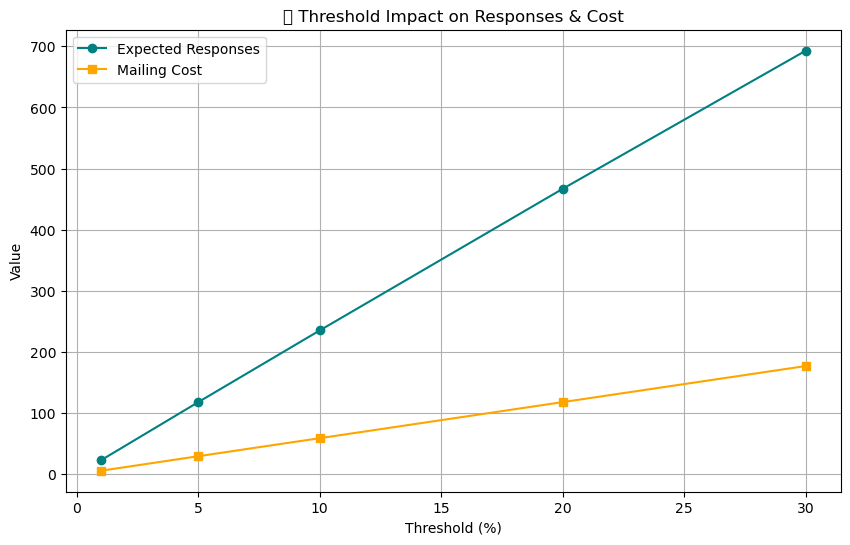

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(threshold_df_actual["Threshold %"], threshold_df_actual["Expected Responses"], marker='o', label="Expected Responses", color='teal')
plt.plot(threshold_df_actual["Threshold %"], threshold_df_actual["Total Mailing Cost (USD)"], marker='s', label="Mailing Cost", color='orange')
plt.xlabel("Threshold (%)")
plt.ylabel("Value")
plt.title("📈 Threshold Impact on Responses & Cost")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
segment_plan = (
    df.groupby(["prdt_type", "campaign_month", "milestone",'cust_segment'])
      .agg(
          total_customers=("response_score", "count"),
          expected_responses=("response_score", "sum"),
          avg_score=("response_score", "mean")
      )
      .reset_index()
      .sort_values(by="expected_responses", ascending=False)
)


In [29]:
segment_plan.sort_values(by="campaign_month")

,prdt_type,campaign_month,milestone,cust_segment,total_customers,expected_responses,avg_score
4,Prdt-1,APRIL,12 Months,Recall12CLExamOnly,1,0.950000,0.95000
636,Prdt-2,APRIL,12 Months,EGRecall12Promo,1,0.970000,0.97000
18,Prdt-1,APRIL,21 Months,CLRecall21Exam,1,0.950000,0.95000
643,Prdt-2,APRIL,15 Months,EGRecall15PromoControl,1,0.000000,0.00000
641,Prdt-2,APRIL,15 Months,EGRecall15ExamControl,1,0.000000,0.00000
...,...,...,...,...,...,...,...
1772,Prdt-2,OCTOBER,27 Months,NVIPC650-EG SV Rec,2,1.000000,0.50000
1707,Prdt-2,OCTOBER,18 Months,Recall Employed-CG,2,0.991381,0.49569
585,Prdt-1,OCTOBER,15 Months,NVIPC637-CL Recall,2,0.990000,0.49500
1713,Prdt-2,OCTOBER,21 Months,-Recall Exam NV-CG,2,0.020000,0.01000


In [31]:
segment_plan = (
    df.groupby(["prdt_type", "campaign_month", "milestone", "cust_segment"])
      .agg(
          total_customers=("response_score", "count"),
          expected_responses=("response_score", "sum"),
          avg_score=("response_score", "mean"),
          actual_revenue=("response_sales_amt", "sum")  
      )
      .reset_index()
      .sort_values(by="expected_responses", ascending=False)
)


In [32]:
# segment_plan.to_csv(" Campaign_Segment_Performance.csv",index=False)

In [ ]:
# threshold_df_actual.to_csv("  Threshold_ROI_Summary.csv",index=False)